In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_pickle(r'assets/models/joey_cnn_intraday/history_100epochs_2classes.pkl')

In [2]:
df

{'loss': [3.2875282764434814,
  0.5117197036743164,
  0.4977438747882843,
  0.45082318782806396,
  0.4420986771583557,
  0.4377845227718353,
  0.43135932087898254,
  0.4138038754463196,
  0.4096740782260895,
  0.4000357389450073,
  0.4066690504550934,
  0.395231693983078,
  0.3961821496486664,
  0.3812997043132782,
  0.38437098264694214,
  0.3672105073928833,
  0.3727593421936035,
  0.37688586115837097,
  0.37306803464889526,
  0.36812153458595276,
  0.3632654845714569,
  0.3651966452598572,
  0.37246406078338623,
  0.3645685911178589,
  0.3659784197807312,
  0.3559442162513733,
  0.36182674765586853,
  0.3559531271457672,
  0.3623865246772766,
  0.3523715138435364,
  0.35060468316078186,
  0.3493083715438843,
  0.3485933542251587,
  0.3622016906738281,
  0.34274423122406006,
  0.34510838985443115,
  0.3444952368736267,
  0.33037951588630676,
  0.3295113742351532,
  0.34179818630218506,
  0.33406949043273926,
  0.33718782663345337,
  0.32352301478385925,
  0.3250207006931305,
  0.32789

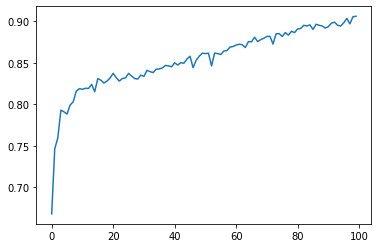

In [3]:
plt.plot(df['binary_accuracy'])

In [4]:
df = pd.read_csv('assets/short_term_symbols/AMD.csv').drop(columns=['Unnamed: 0'])
df = df.reindex(index=df.index[::-1])
df['time'] = pd.to_datetime(df['time'])
df = df.set_index(df['time']).drop(columns=['time'])
df = df.resample('5min').first()
df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].ffill()
df['volume'] = df['volume'].fillna(0)

df2 = pd.read_csv('assets/short_term_symbols/NVDA.csv').drop(columns=['Unnamed: 0'])
df2 = df2.reindex(index=df2.index[::-1])
df2['time'] = pd.to_datetime(df2['time'])
df2 = df2.set_index(df2['time']).drop(columns=['time'])
df2 = df2.resample('5min').first()
df2[['open', 'high', 'low', 'close']] = df2[['open', 'high', 'low', 'close']].ffill()
df2['volume'] = df2['volume'].fillna(0)

pd.concat([df.add_prefix('AMD_'), df2.add_prefix('NVDA_')], axis=1, join='outer')

,AMD_open,AMD_high,AMD_low,AMD_close,AMD_volume,NVDA_open,NVDA_high,NVDA_low,NVDA_close,NVDA_volume
time,,,,,,,,,,
2019-08-01 04:05:00,30.9400,30.9400,30.55,30.56,10066.0,NaN,NaN,NaN,NaN,NaN
2019-08-01 04:10:00,30.5400,30.5400,30.54,30.54,406.0,NaN,NaN,NaN,NaN,NaN
2019-08-01 04:15:00,30.5100,30.5200,30.51,30.52,502.0,NaN,NaN,NaN,NaN,NaN
2019-08-01 04:20:00,30.5100,30.5200,30.51,30.52,0.0,NaN,NaN,NaN,NaN,NaN
2019-08-01 04:25:00,30.5600,30.5600,30.56,30.56,137.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-07-19 19:40:00,87.2600,87.3000,87.24,87.24,7783.0,759.00,759.00,759.00,759.00,761.0
2021-07-19 19:45:00,87.2000,87.2300,87.20,87.23,1012.0,759.25,759.83,759.25,759.50,634.0
2021-07-19 19:50:00,87.2300,87.2400,87.23,87.24,955.0,759.50,759.75,759.40,759.75,3347.0


In [5]:
results = pd.read_csv('assets/short_term_symbols/total.csv')
results['time'] = pd.to_datetime(results['time'])
results = results.set_index(results['time']).drop(columns=['time'])
results = results.loc['2020-07-20 04:05:00':]
results.head()

,NVDA_open,NVDA_high,NVDA_low,NVDA_close,NVDA_volume,AMD_open,AMD_high,AMD_low,AMD_close,AMD_volume,...,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,QQQ_open,QQQ_high,QQQ_low,QQQ_close,QQQ_volume
time,,,,,,,,,,,,,,,,,,,,,
2020-07-20 04:05:00,101.908985,101.908985,101.908985,101.908985,0.0,54.94,54.99,54.94,54.99,550.0,...,315.188965,315.326894,315.139704,315.139704,5853.0,256.555004,256.614666,256.485399,256.485399,7286.0
2020-07-20 04:10:00,101.908985,101.908985,101.908985,101.908985,0.0,54.94,54.99,54.94,54.99,0.0,...,315.169260,315.208669,315.021479,315.021479,2636.0,256.455568,256.505286,256.385963,256.415794,4396.0
2020-07-20 04:15:00,101.908985,101.908985,101.908985,101.908985,0.0,54.94,54.99,54.94,54.99,0.0,...,315.070739,315.070739,314.893401,314.962366,1151.0,256.445625,256.455568,256.336245,256.336245,1965.0
2020-07-20 04:20:00,101.908985,101.908985,101.908985,101.908985,0.0,54.75,54.75,54.75,54.75,227.0,...,314.962366,315.228373,314.942662,315.149556,3338.0,256.376019,256.594779,256.366076,256.555004,6474.0
2020-07-20 04:25:00,101.908985,101.908985,101.908985,101.908985,0.0,54.74,54.74,54.74,54.74,321.0,...,315.139704,315.139704,315.070739,315.070739,930.0,256.574891,256.594779,256.545061,256.594779,1747.0


In [6]:
for time in range(0, results.shape[0]):
    print(results.iloc[time].name.minute == 1 and 1 == 2)
    break

False
